# Dự đoán PE của VCB bằng Support Vector Regression (SVR)

Notebook này thực hiện phân tích và dự đoán chỉ số PE (Price-to-Earnings) của VCB trong 10 năm tới sử dụng mô hình Support Vector Regression với RBF kernel.

## Mục tiêu:
- Phân tích dữ liệu PE lịch sử của VCB
- Xây dựng mô hình SVR để dự đoán
- Sử dụng Feature Scaling để tối ưu hóa SVR
- Dự báo PE cho 10 năm tới (40 quý)

## 1. Import Required Libraries

Import các thư viện cần thiết cho SVR và feature scaling.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print("✅ Đã import thành công tất cả thư viện cần thiết cho SVR!")

✅ Đã import thành công tất cả thư viện cần thiết cho SVR!


## 2. Importing and Preprocessing the VCB Dataset

Đọc dữ liệu VCB từ file CSV và tiền xử lý dữ liệu tương tự như Linear Regression.

In [5]:
# Đọc dữ liệu từ file CSV
dataset = pd.read_csv('VCB.csv')
print("Dữ liệu gốc:")
print(dataset.head())
print(f"Shape ban đầu: {dataset.shape}")

# Loại bỏ các dòng trống
dataset = dataset.dropna()
print(f"\nShape sau khi loại bỏ dòng trống: {dataset.shape}")

# Hàm chuyển đổi định dạng thời gian từ "2024 Q1" thành số
def convert_quarter_to_number(quarter_str):
    year, quarter = quarter_str.split(' ')
    year = int(year)
    quarter_num = int(quarter[1])  # Extract number from Q1, Q2, etc.
    # Convert to sequential number (starting from 2019 Q1 = 1)
    return (year - 2019) * 4 + quarter_num

# Áp dụng hàm chuyển đổi
dataset['time_numeric'] = dataset['thoigian'].apply(convert_quarter_to_number)

# Sắp xếp theo thời gian để đảm bảo thứ tự đúng
dataset = dataset.sort_values('time_numeric')

# Tạo biến X (features) và y (target)
X = dataset[['time_numeric']].values
y = dataset['pe'].values

print(f"\nThông tin dataset sau xử lý:")
print(f"Dataset shape: {dataset.shape}")
print(f"Time range: {dataset['thoigian'].min()} to {dataset['thoigian'].max()}")
print(f"PE range: {y.min():.2f} to {y.max():.2f}")
print(f"\nDữ liệu sau xử lý:")
print(dataset[['thoigian', 'pe', 'time_numeric']].head(10))

Dữ liệu gốc:
  thoigian         pe
0  2024 Q1  15.613789
1  2023 Q4  12.465656
2  2023 Q3  12.744359
3  2023 Q2  14.605449
4  2023 Q1  13.990960
Shape ban đầu: (42, 2)

Shape sau khi loại bỏ dòng trống: (22, 2)

Thông tin dataset sau xử lý:
Dataset shape: (22, 3)
Time range: 2019 Q1 to 2024 Q2
PE range: 12.29 to 21.03

Dữ liệu sau xử lý:
   thoigian         pe  time_numeric
20  2019 Q1  15.418478             1
19  2019 Q2  14.913664             2
18  2019 Q3  15.570829             3
17  2019 Q4  18.069681             4
16  2020 Q1  12.786029             5
15  2020 Q2  16.333462             6
14  2020 Q3  18.159528             7
13  2020 Q4  19.678818             8
12  2021 Q1  16.603832             9
11  2021 Q2  21.032824            10


## 3. Feature Scaling

SVR yêu cầu feature scaling để hoạt động hiệu quả. Chúng ta sẽ sử dụng StandardScaler cho cả X và y.

In [6]:
# Khởi tạo StandardScaler cho X và y
sc_X = StandardScaler()
sc_y = StandardScaler()

# Reshape y để phù hợp với StandardScaler (cần 2D array)
y_reshaped = y.reshape(-1, 1)

# Fit và transform dữ liệu
X_scaled = sc_X.fit_transform(X)
y_scaled = sc_y.fit_transform(y_reshaped).flatten()  # Flatten để trở về 1D

print("📊 Feature Scaling đã hoàn thành!")
print(f"X gốc - Min: {X.min():.2f}, Max: {X.max():.2f}")
print(f"X scaled - Min: {X_scaled.min():.2f}, Max: {X_scaled.max():.2f}")
print(f"y gốc - Min: {y.min():.2f}, Max: {y.max():.2f}")
print(f"y scaled - Min: {y_scaled.min():.2f}, Max: {y_scaled.max():.2f}")

print(f"\n📊 Sẽ train trên toàn bộ dataset: {X_scaled.shape[0]} mẫu")

📊 Feature Scaling đã hoàn thành!
X gốc - Min: 1.00, Max: 22.00
X scaled - Min: -1.66, Max: 1.66
y gốc - Min: 12.29, Max: 21.03
y scaled - Min: -1.22, Max: 2.43

📊 Sẽ train trên toàn bộ dataset: 22 mẫu


## 4. Training the Support Vector Regression Model

Huấn luyện mô hình SVR với RBF kernel trên dữ liệu đã được scaling.

In [7]:
# Khởi tạo và huấn luyện mô hình SVR với RBF kernel trên toàn bộ dataset
regressor = SVR(kernel='rbf')
regressor.fit(X_scaled, y_scaled)

print("🎉 Mô hình SVR đã được huấn luyện thành công!")
print(f"🔧 Kernel: RBF")
print(f"📊 Số support vectors: {regressor.n_support_}")
print(f"📈 Trained trên {X_scaled.shape[0]} mẫu dữ liệu")

# Dự đoán trên toàn bộ dataset để kiểm tra fit
y_pred_all_scaled = regressor.predict(X_scaled)
y_pred_all = sc_y.inverse_transform(y_pred_all_scaled.reshape(-1, 1)).flatten()

print(f"\n📊 Thống kê dự đoán trên toàn bộ dataset:")
print(f"PE thực tế - Trung bình: {np.mean(y):.2f}, Độ lệch chuẩn: {np.std(y):.2f}")
print(f"PE dự đoán - Trung bình: {np.mean(y_pred_all):.2f}, Độ lệch chuẩn: {np.std(y_pred_all):.2f}")

🎉 Mô hình SVR đã được huấn luyện thành công!
🔧 Kernel: RBF
📊 Số support vectors: [20]
📈 Trained trên 22 mẫu dữ liệu

📊 Thống kê dự đoán trên toàn bộ dataset:
PE thực tế - Trung bình: 15.21, Độ lệch chuẩn: 2.39
PE dự đoán - Trung bình: 14.97, Độ lệch chuẩn: 1.42


## 5. Predicting PE for the Next 10 Years

Sử dụng mô hình SVR đã huấn luyện để dự đoán PE cho 10 năm tới.

In [8]:
# Lấy điểm thời gian cuối cùng trong dataset
last_time = dataset['time_numeric'].max()
print(f"Điểm thời gian cuối cùng trong dataset: {last_time}")

# Tạo các điểm thời gian tương lai cho 10 năm (40 quý)
future_quarters = 40
future_time_points = np.array([[last_time + i + 1] for i in range(future_quarters)])

# Scale dữ liệu tương lai sử dụng scaler đã fit
future_time_points_scaled = sc_X.transform(future_time_points)

# Dự đoán giá trị PE tương lai (scaled)
future_pe_pred_scaled = regressor.predict(future_time_points_scaled)

# Chuyển đổi dự đoán về scale gốc
future_pe_pred = sc_y.inverse_transform(future_pe_pred_scaled.reshape(-1, 1)).flatten()

# Hàm chuyển đổi số thành định dạng quý
def convert_number_to_quarter(time_num):
    quarter_in_year = ((time_num - 1) % 4) + 1
    year = 2019 + (time_num - 1) // 4
    return f"{year} Q{quarter_in_year}"

# Tạo nhãn cho các quý tương lai
future_quarters_labels = [convert_number_to_quarter(last_time + i + 1) for i in range(future_quarters)]

# Hiển thị dự đoán
print("\n🔮 === DỰ ĐOÁN PE VỚI SVR CHO 10 NĂM TỚI ===")
print("=" * 55)
for i, (quarter, pe_val) in enumerate(zip(future_quarters_labels, future_pe_pred)):
    print(f"{quarter}: {pe_val:.2f}")
    if (i + 1) % 4 == 0:  # Thêm dòng trống sau mỗi năm
        print("-" * 35)

Điểm thời gian cuối cùng trong dataset: 22

🔮 === DỰ ĐOÁN PE VỚI SVR CHO 10 NĂM TỚI ===
2024 Q3: 14.77
2024 Q4: 14.93
2025 Q1: 15.04
2025 Q2: 15.09
-----------------------------------
2025 Q3: 15.11
2025 Q4: 15.11
2026 Q1: 15.09
2026 Q2: 15.07
-----------------------------------
2026 Q3: 15.05
2026 Q4: 15.04
2027 Q1: 15.02
2027 Q2: 15.02
-----------------------------------
2027 Q3: 15.01
2027 Q4: 15.01
2028 Q1: 15.01
2028 Q2: 15.01
-----------------------------------
2028 Q3: 15.01
2028 Q4: 15.00
2029 Q1: 15.00
2029 Q2: 15.00
-----------------------------------
2029 Q3: 15.00
2029 Q4: 15.00
2030 Q1: 15.00
2030 Q2: 15.00
-----------------------------------
2030 Q3: 15.00
2030 Q4: 15.00
2031 Q1: 15.00
2031 Q2: 15.00
-----------------------------------
2031 Q3: 15.00
2031 Q4: 15.00
2032 Q1: 15.00
2032 Q2: 15.00
-----------------------------------
2032 Q3: 15.00
2032 Q4: 15.00
2033 Q1: 15.00
2033 Q2: 15.00
-----------------------------------
2033 Q3: 15.00
2033 Q4: 15.00
2034 Q1: 15.00
203

## 6. Visualizing the SVR Results

Trực quan hóa dữ liệu lịch sử, mô hình SVR và dự đoán tương lai.

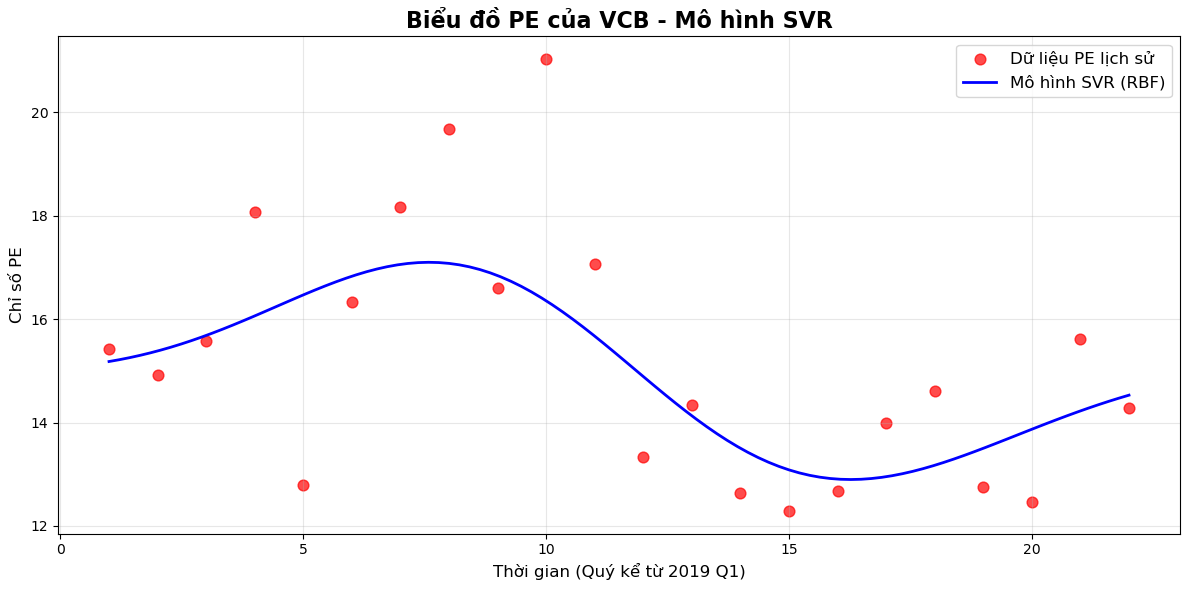

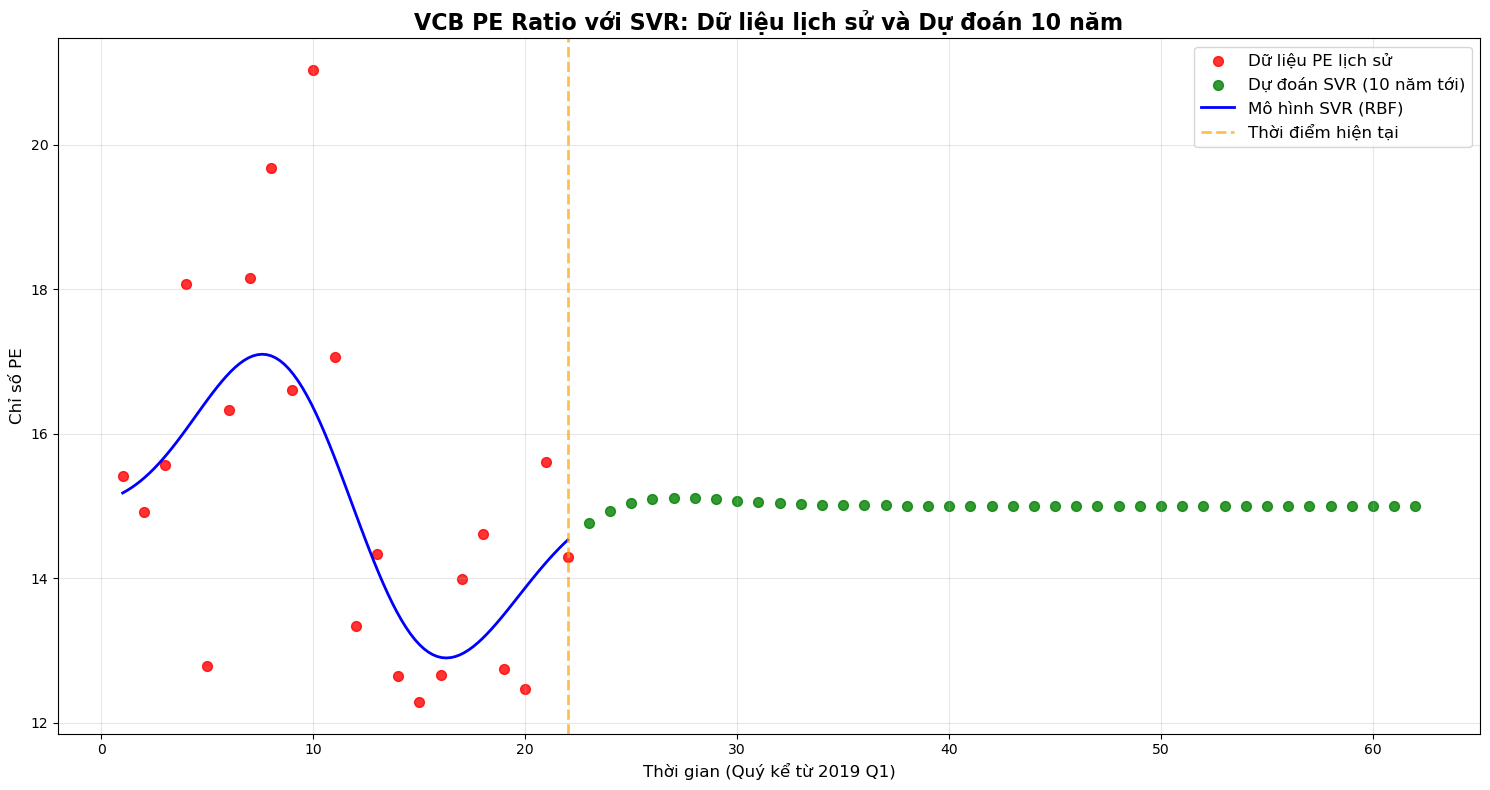

🔮 Tóm tắt dự đoán SVR tương lai:
PE dự đoán cho 10 năm tới - Trung bình: 15.01
PE dự đoán - Giá trị thấp nhất: 14.77
PE dự đoán - Giá trị cao nhất: 15.11
Độ lệch chuẩn dự đoán: 0.05


In [9]:
# Tạo dữ liệu để vẽ đường SVR trên toàn bộ dải
X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_plot_scaled = sc_X.transform(X_plot)
y_plot_scaled = regressor.predict(X_plot_scaled)
y_plot = sc_y.inverse_transform(y_plot_scaled.reshape(-1, 1)).flatten()

# Vẽ biểu đồ so sánh dữ liệu lịch sử và mô hình SVR
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='red', label='Dữ liệu PE lịch sử', s=60, alpha=0.7)
plt.plot(X_plot, y_plot, color='blue', label='Mô hình SVR (RBF)', linewidth=2)
plt.title('Biểu đồ PE của VCB - Mô hình SVR', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian (Quý kể từ 2019 Q1)', fontsize=12)
plt.ylabel('Chỉ số PE', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ kết hợp lịch sử và dự đoán tương lai
all_time_points = np.concatenate([X.flatten(), future_time_points.flatten()])

plt.figure(figsize=(15, 8))
plt.scatter(X, y, color='red', label='Dữ liệu PE lịch sử', s=50, alpha=0.8)
plt.scatter(future_time_points, future_pe_pred, color='green', label='Dự đoán SVR (10 năm tới)', s=50, alpha=0.8)

# Vẽ đường SVR cho dữ liệu lịch sử
plt.plot(X_plot, y_plot, color='blue', label='Mô hình SVR (RBF)', linewidth=2)

# Thêm đường thẳng đứng để phân tách dữ liệu lịch sử và dự đoán
plt.axvline(x=last_time, color='orange', linestyle='--', alpha=0.7, label='Thời điểm hiện tại', linewidth=2)

plt.title('VCB PE Ratio với SVR: Dữ liệu lịch sử và Dự đoán 10 năm', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian (Quý kể từ 2019 Q1)', fontsize=12)
plt.ylabel('Chỉ số PE', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# In thông tin tóm tắt về dự đoán tương lai
print("🔮 Tóm tắt dự đoán SVR tương lai:")
print(f"PE dự đoán cho 10 năm tới - Trung bình: {np.mean(future_pe_pred):.2f}")
print(f"PE dự đoán - Giá trị thấp nhất: {np.min(future_pe_pred):.2f}")
print(f"PE dự đoán - Giá trị cao nhất: {np.max(future_pe_pred):.2f}")
print(f"Độ lệch chuẩn dự đoán: {np.std(future_pe_pred):.2f}")